
**Reading the Streamed JSON Documents from MongoDB into a dataframe:**




In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from google.colab import auth
from google.colab import drive

In [ ]:
spark = SparkSession.builder \
    .appName("MongoDBExportToCSV") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/project_budt737.airbnb_data") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/project_budt737.airbnb_data") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .getOrCreate()

# Set log level to ERROR to reduce verbosity
spark.sparkContext.setLogLevel("ERROR")

In [ ]:
df = spark.read.format("mongo").load()

**Picking columns and creating Nodes file:**

In [ ]:
# Selecting the specified columns
edges_df = df.select("host_id", "state", "country", "city")

# Writing the DataFrame to a CSV file
edges_df.write.csv("Nodes.csv", header=True)

**Picking columns and creating the Edges file:**

In [ ]:
# Selecting the specified columns
edges_df = df.select("host_id", "neighbourhood")

# Writing the DataFrame to a CSV file
edges_df.write.csv("Edges.csv", header=True)

In [ ]:
#Installing the necessary libraries
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://bitbucket.org/habedi/datasets/raw/b6769c4664e7ff68b001e2f43bc517888cbe3642/spark/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!rm -rf spark-3.0.2-bin-hadoop2.7.tgz*
!pip -q install findspark pyspark graphframes

In [ ]:
#Initializing the environment
import os
os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell"

In [ ]:
from graphframes import *
from pyspark import *
from pyspark.sql import *
spark = SparkSession.builder.appName('myfunction').getOrCreate()


*   The Nodes and Edges are prepared from the streaming file obtained. The Nodes comprisies of host id's, state, country and city. The edges file has host id's and neighbourhoods.

*   Misisng data has been substituted with NULL.



**Reading the data:**

In [ ]:
vertices = spark.read.option('header', 'true').csv('Nodes.csv')
edges = spark.read.option('header', 'true').csv('Edges.csv')

In [ ]:
vertices.show()
edges.show()

+---------+-----+-------------+---------+
|       id|state|      country|     city|
+---------+-----+-------------+---------+
|  2676750|   NY|United States| New York|
|  5179817|   NY|United States| New York|
|102032572|   NY|United States| Brooklyn|
| 32625342|   NY|United States|    Bronx|
| 23726672|   NY|United States| New York|
| 75275467|   NY|United States|    Bronx|
| 87588590|   NY|United States| New York|
| 50553518|   NY|United States| New York|
| 10134825|   NY|United States| New York|
| 49523428|   NY|United States| New York|
| 39863496|   NY|United States| New York|
| 10278592|   NY|United States| Brooklyn|
| 17279490|   NY|United States| New York|
| 36232131|   NY|United States|   Quenns|
| 72677655|   NY|United States| New York|
|  5808572|   NY|United States| Brooklyn|
|  1837590|   NY|United States| Brooklyn|
|  6471461|   NY|United States|Ridgewood|
|106423705|   NY|United States| New York|
|  1962620|   NY|United States| New York|
+---------+-----+-------------+---

**Creating Graphs:**

In [ ]:
mygraph = GraphFrame(vertices, edges)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [ ]:
#Displaying the vertices of graph
mygraph.vertices.show()

#Displaying the edges of graph
mygraph.edges.show()

+---------+-----+-------------+---------+
|       id|state|      country|     city|
+---------+-----+-------------+---------+
|  2676750|   NY|United States| New York|
|  5179817|   NY|United States| New York|
|102032572|   NY|United States| Brooklyn|
| 32625342|   NY|United States|    Bronx|
| 23726672|   NY|United States| New York|
| 75275467|   NY|United States|    Bronx|
| 87588590|   NY|United States| New York|
| 50553518|   NY|United States| New York|
| 10134825|   NY|United States| New York|
| 49523428|   NY|United States| New York|
| 39863496|   NY|United States| New York|
| 10278592|   NY|United States| Brooklyn|
| 17279490|   NY|United States| New York|
| 36232131|   NY|United States|   Quenns|
| 72677655|   NY|United States| New York|
|  5808572|   NY|United States| Brooklyn|
|  1837590|   NY|United States| Brooklyn|
|  6471461|   NY|United States|Ridgewood|
|106423705|   NY|United States| New York|
|  1962620|   NY|United States| New York|
+---------+-----+-------------+---

**Host having multiple listings in different neighborhoods:**

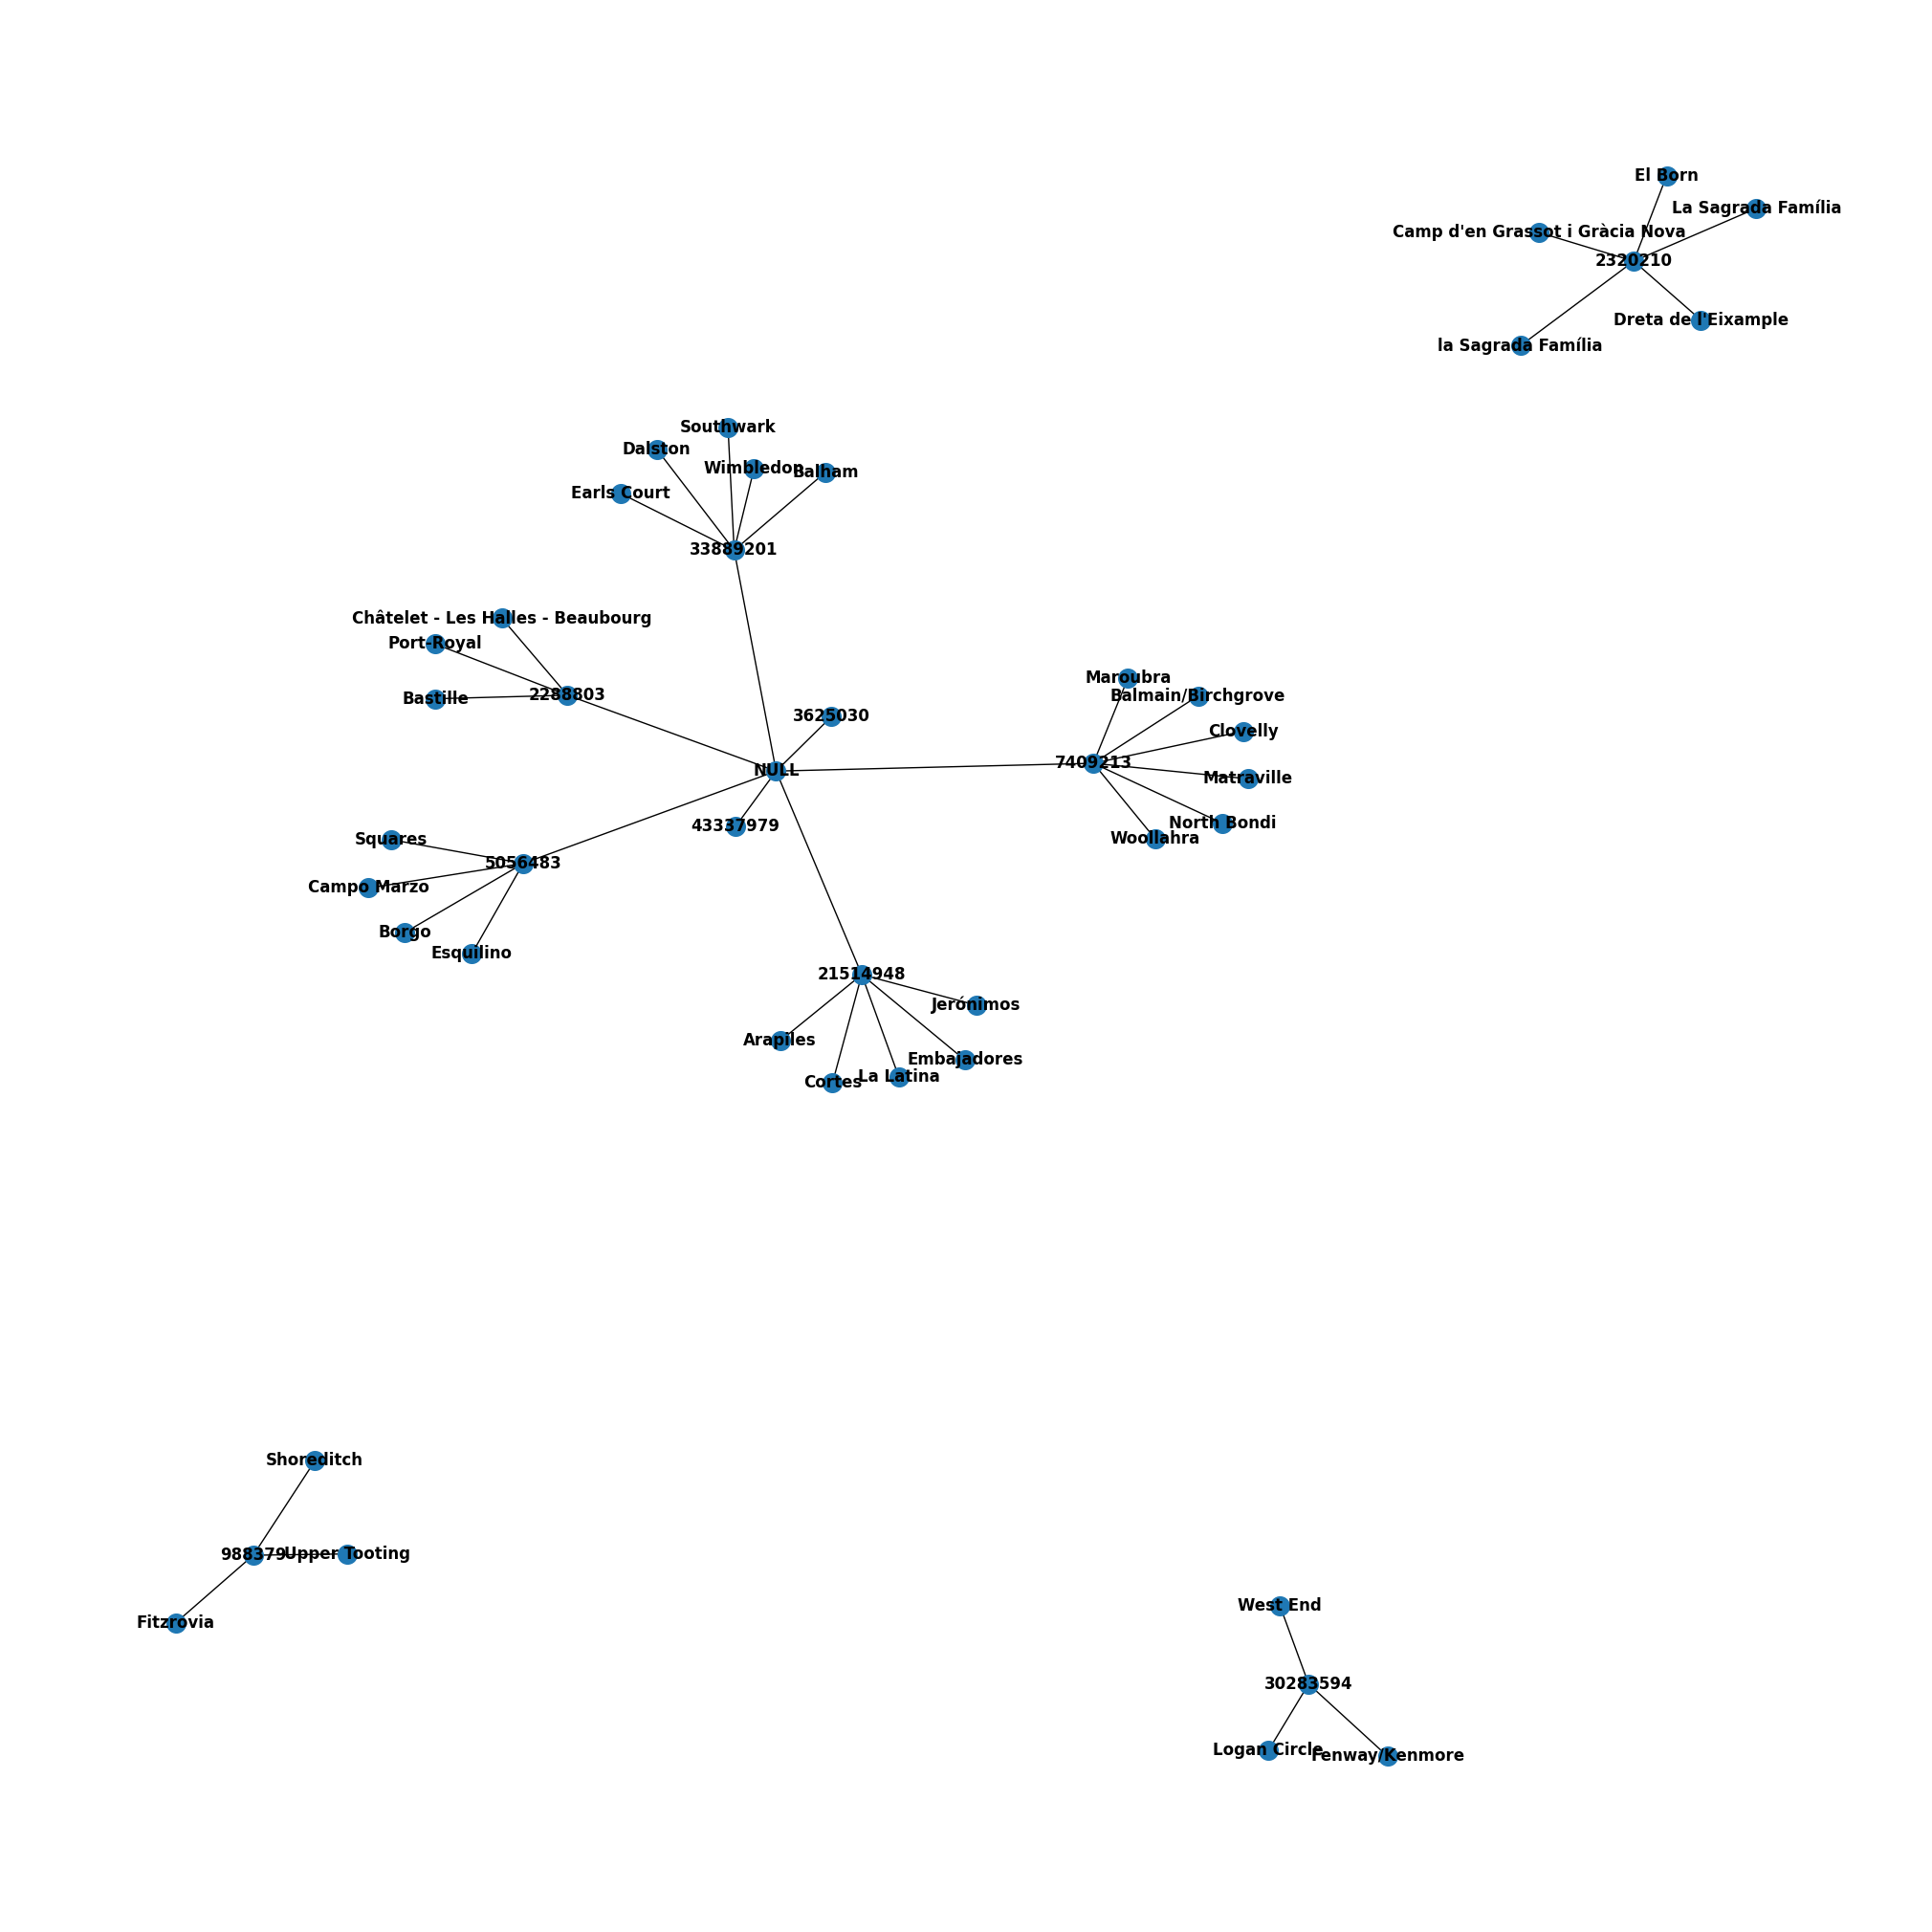

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_undirected_graph(edge_list, top_n=10):
    plt.figure(figsize=(20, 20))
    gplot = nx.Graph()

    # Count the occurrences of each source node
    source_counts = edge_list.groupBy("src").count()

    # Get the top N source nodes with the most destinations
    top_sources = source_counts.orderBy("count", ascending=False).limit(top_n).select("src").rdd.flatMap(lambda x: x).collect()

    # Add only the top sources and their edges to the graph
    for row in edge_list.filter(edge_list["src"].isin(top_sources)).select("src", "dst").collect():
        gplot.add_edge(row["src"], row["dst"])

    # Draw the graph
    nx.draw(gplot, with_labels=True, font_weight="bold", node_size=200)

# Assuming mygraph is a GraphFrame with an 'edges' attribute
plot_undirected_graph(mygraph.edges, top_n=10)
plt.show()


[OPTIONAL TO USE]

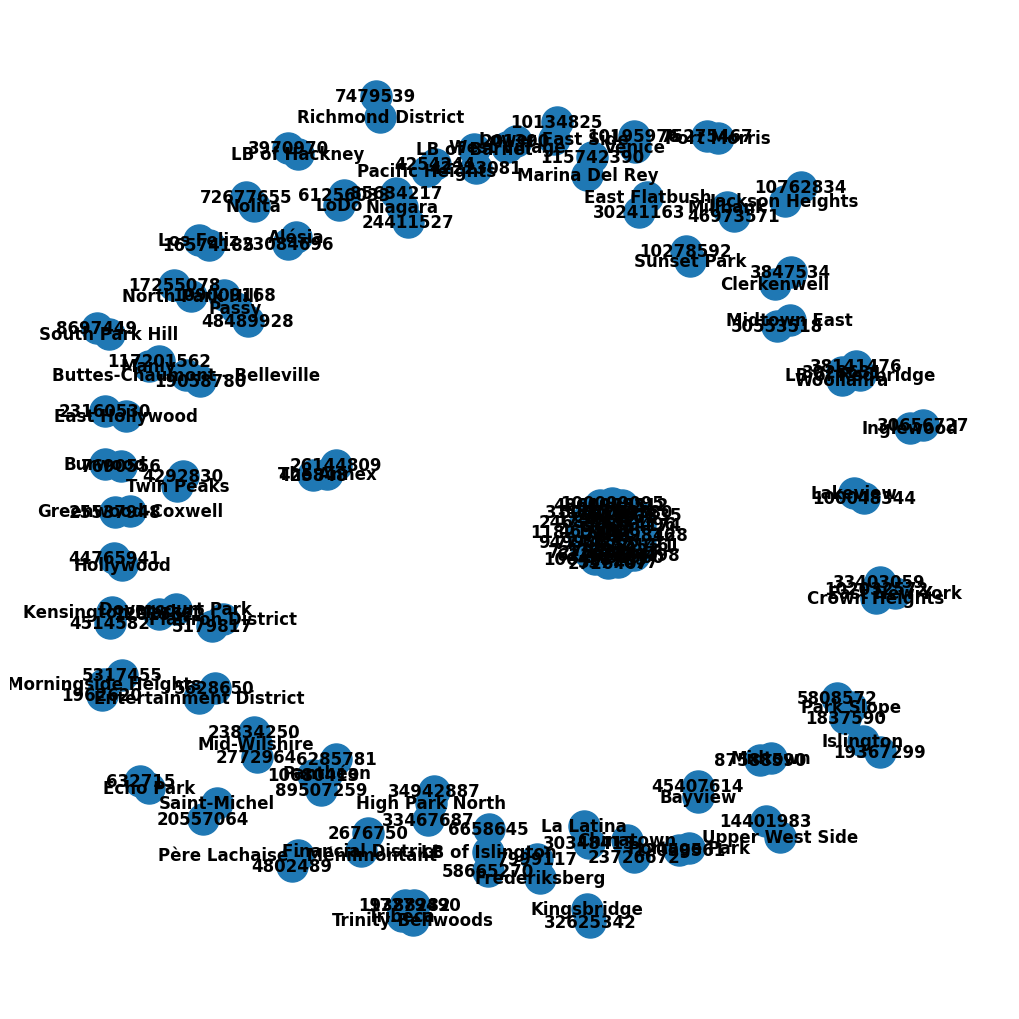

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
def plot_undirected_graph(edge_list):
    plt.figure(figsize=(10,10))
    gplot=nx.Graph()
    for row in edge_list.select("src", "dst").take(100):
        gplot.add_edge(row["src"], row["dst"])
    nx.draw(gplot, with_labels=True, font_weight="bold", node_size=500)
plot_undirected_graph(mygraph.edges)

Only displaying nodes with multiple edges: [OPTIONAL TO USE]

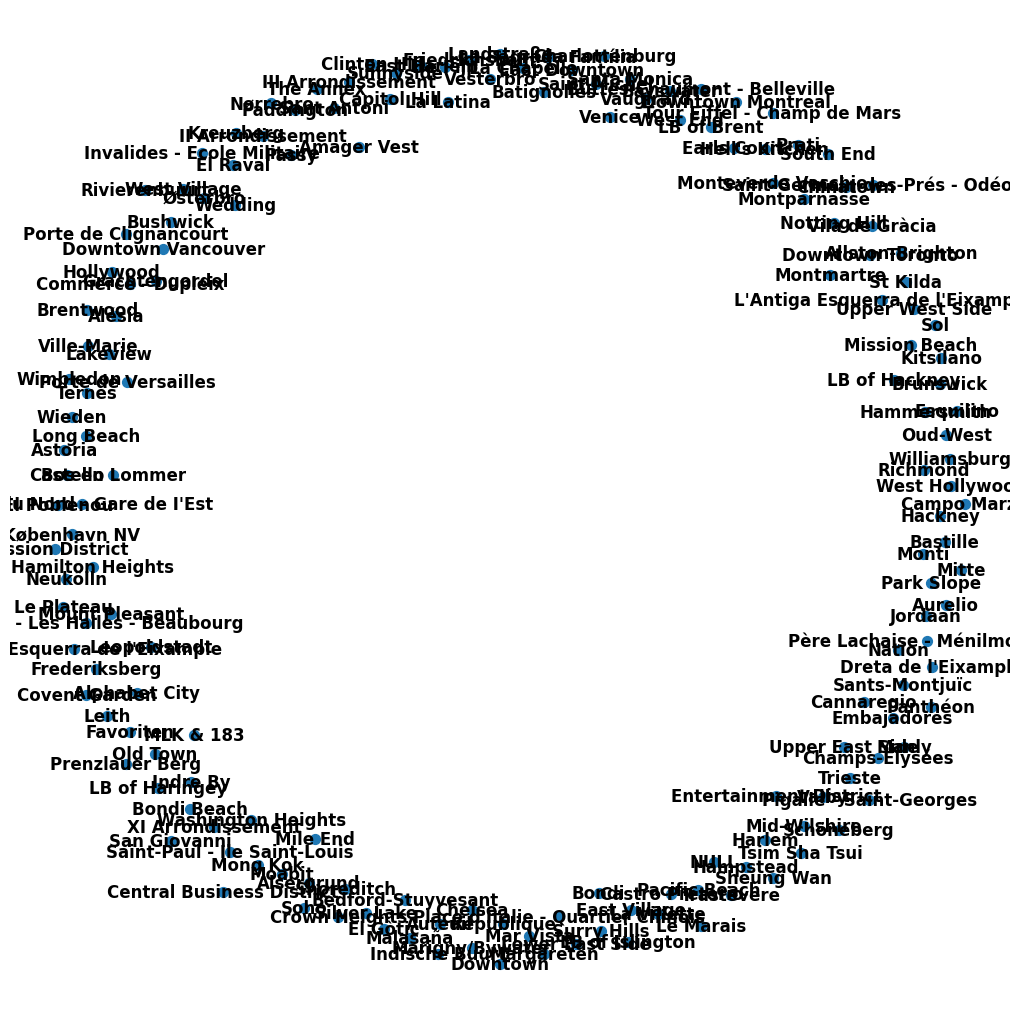

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_undirected_graph(edge_list):
    plt.figure(figsize=(10, 10))
    gplot = nx.Graph()

    # Add edges to the graph
    for row in edge_list.select("src", "dst").collect():
        gplot.add_edge(row["src"], row["dst"])

    # Filter nodes with degree greater than 3
    filtered_nodes = [node for node, degree in dict(gplot.degree()).items() if degree > 10]

    # Create a subgraph with only the filtered nodes and their edges
    subgraph = gplot.subgraph(filtered_nodes)

    # Draw the subgraph
    nx.draw(subgraph, with_labels=True, font_weight="bold", node_size=50)

# Assuming mygraph is a GraphFrame with an 'edges' attribute
plot_undirected_graph(mygraph.edges)
plt.show()
